In [1]:
from google.colab import files
uploaded = files.upload()


Saving AI_DATA.csv to AI_DATA.csv


In [2]:
import pandas as pd

# Load the dataset (uploaded is assumed to be a dict of uploaded files)
df = pd.read_csv(next(iter(uploaded)))

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Select only required columns
df = df[['Course credit',
         'how many hours did you study each week for this subject?',
         'Attendance Rate (%) (Number)',
         'Assignment Score out of 30',
         'Final Exam Results']]

# Rename columns to shorter names
df.rename(columns={
    'Course credit': 'Credit',
    'how many hours did you study each week for this subject?': 'Weekly Study Hours',
    'Attendance Rate (%) (Number)': 'Attendance',
    'Assignment Score out of 30': 'Assignment Score',
    'Final Exam Results': 'Exam Grades'
}, inplace=True)

# Preview the cleaned and renamed columns
print("Cleaned & Renamed Column Names:\n", df.columns.tolist())

# Preview first 5 rows
print(df.head())


Cleaned & Renamed Column Names:
 ['Credit', 'Weekly Study Hours', 'Attendance', 'Assignment Score', 'Exam Grades']
   Credit  Weekly Study Hours Attendance  Assignment Score Exam Grades
0       2                   2    90 - 99                21          B-
1       2                   2    90 - 99                20          B-
2       2                   2    90 - 99                21          B-
3       4                   3    90 - 99                27          B+
4       4                   3    90 - 99                26          B+


In [3]:
print("Missing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Credit                0
Weekly Study Hours    0
Attendance            0
Assignment Score      0
Exam Grades           1
dtype: int64


In [4]:

def attendance_range_to_avg(value):
    if isinstance(value, str) and '-' in value:
        start, end = value.split('-')
        return (float(start.strip()) + float(end.strip())) / 2
    try:
        return float(value)
    except:
        return None  # or np.nan

# Apply the function to the Attendance column
df['Attendance'] = df['Attendance'].apply(attendance_range_to_avg)

# Check result
print(df['Attendance'].head())


0    94.5
1    94.5
2    94.5
3    94.5
4    94.5
Name: Attendance, dtype: float64


In [5]:
def simplify_grades(grade):
    grade = str(grade).strip().upper()
    if grade in ['A+', 'A', 'A-']:
        return 'A'
    elif grade in ['B+', 'B', 'B-']:
        return 'B'
    elif grade in ['C+', 'C']:
        return 'C'
    elif grade in ['C-', 'D+', 'D']:
        return 'D'
    else:
        return 'E'

# Apply to your column
df['Exam Grades'] = df['Exam Grades'].apply(simplify_grades)

# Preview result
print(df['Exam Grades'].value_counts())


Exam Grades
B    312
C    274
A    259
D     92
E     65
Name: count, dtype: int64


In [6]:
# Nicer preview in notebook
df.head(10)


,Credit,Weekly Study Hours,Attendance,Assignment Score,Exam Grades
0,2,2,94.5,21,B
1,2,2,94.5,20,B
2,2,2,94.5,21,B
3,4,3,94.5,27,B
4,4,3,94.5,26,B
5,4,3,94.5,26,B
6,2,1,64.5,10,D
7,4,1,84.5,10,D
8,4,2,84.5,18,D
9,2,1,64.5,10,D


In [7]:
# Features and label
X = df[['Credit', 'Weekly Study Hours', 'Attendance', 'Assignment Score']]
y = df['Exam Grades']  # use grade labels like A, B, C


In [8]:
X = X.dropna()
y = y.loc[X.index]  # align y with X


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # A=0, B=1, ...


In [10]:
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3), 'E': np.int64(4)}


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

model = Sequential([
    Input(shape=(X.shape[1],)),           # Input layer
    Dense(128, activation='relu'),        # Hidden layer 1
    Dropout(0.3),                          # Dropout layer 1
    Dense(64, activation='relu'),         # Hidden layer 2
    Dropout(0.3),                          # Dropout layer 2
    Dense(32, activation='relu'),         # Hidden layer 3
    Dropout(0.2),                          # Dropout layer 3
    Dense(5, activation='softmax')        # Output layer (for 5 classes)
])


In [14]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4371 - loss: 1.4816 - val_accuracy: 0.5963 - val_loss: 1.0353
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6226 - loss: 1.0262 - val_accuracy: 0.6708 - val_loss: 0.7776
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6363 - loss: 0.8429 - val_accuracy: 0.7143 - val_loss: 0.6647
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6705 - loss: 0.7863 - val_accuracy: 0.7826 - val_loss: 0.5770
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7027 - loss: 0.7066 - val_accuracy: 0.7329 - val_loss: 0.5695
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7086 - loss: 0.6708 - val_accuracy: 0.7764 - val_loss: 0.5134
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6936 - loss: 0.6861 - val_accuracy: 0.7950 - val_loss: 0.4979
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7452 - loss: 0.6297 - val_accuracy: 0.7516 - val_loss

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7931 - loss: 0.5168 
Test Accuracy: 0.8009950518608093


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

y_true = y_test
y_pred_classes = y_pred.argmax(axis=1)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.8010
Precision: 0.8050
Recall: 0.8010
F1 Score: 0.7949


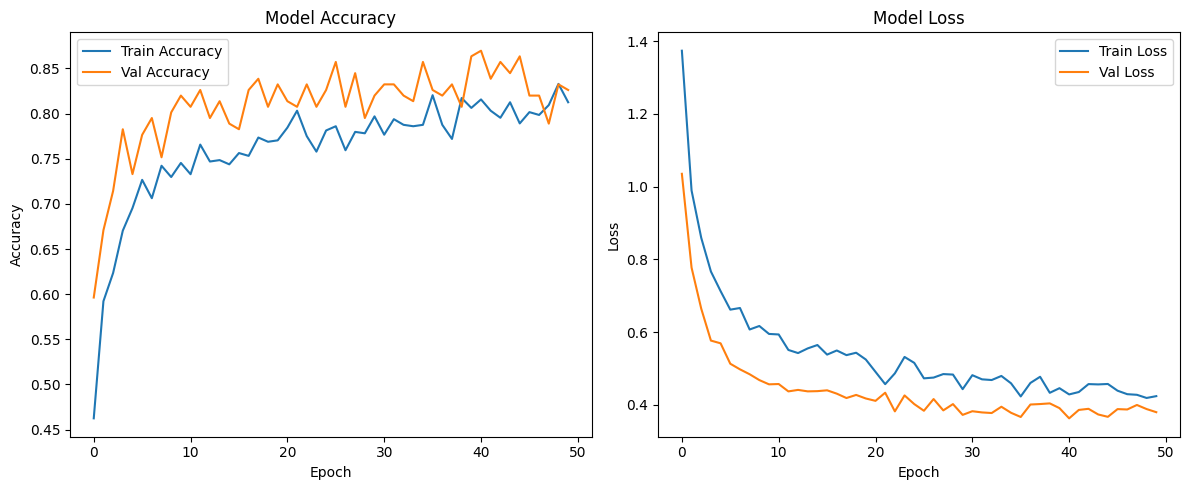

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Ask user for input values
credit = float(input("Enter course credit (e.g., 2): "))
study_hours = float(input("Enter weekly study hours (e.g., 4): "))
attendance = float(input("Enter attendance percentage (e.g., 60): "))
assignment_score = float(input("Enter assignment score out of 30 (e.g., 10): "))

# Combine into a single input array
manual_input = [[credit, study_hours, attendance, assignment_score]]

# Scale the input using your trained scaler
manual_input_scaled = scaler.transform(manual_input)

# Make prediction
prediction = model.predict(manual_input_scaled)

# Round probabilities
rounded_probs = np.round(prediction[0], 4)

# Get label names from encoder
grade_labels = label_encoder.classes_

# Show probability distribution
prob_dict = dict(zip(grade_labels, rounded_probs))
print("\nPrediction Probabilities (rounded):", prob_dict)

# Get predicted class
predicted_class = np.argmax(prediction)
predicted_grade = label_encoder.inverse_transform([predicted_class])
print("Predicted Grade:", predicted_grade[0])